In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset 
df = pd.read_csv("../data/processed/after_EDA.csv")

In [4]:
df.head()

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0.000000,33.6,0.627,50,1
1,1,1,85,66,29,0.000000,26.6,0.351,31,0
2,2,8,183,64,0,0.000000,23.3,0.672,32,1
3,3,1,89,66,23,4.553877,28.1,0.167,21,0
4,4,0,137,40,35,5.129899,43.1,2.288,33,1


In [5]:
df.columns

Index(['Unnamed: 0', 'Pregnancies', 'Glucose', 'BloodPressure',
       'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
       'Outcome'],
      dtype='str')

In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)


In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0.000000,33.6,0.627,50,1
1,1,85,66,29,0.000000,26.6,0.351,31,0
2,8,183,64,0,0.000000,23.3,0.672,32,1
3,1,89,66,23,4.553877,28.1,0.167,21,0
4,0,137,40,35,5.129899,43.1,2.288,33,1


## Split Features and Target

In [8]:
X = df.drop("Outcome",axis=1)
y = df["Outcome"]

In [9]:
print("Shape of X: ",X.shape)
print("Shape of y: ",y.shape)


Shape of X:  (768, 8)
Shape of y:  (768,)


## Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (614, 8)
Testing shape: (154, 8)


## Scaling (VERY IMPORTANT for SVM)

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()

In [15]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train SVM Model

In [16]:
from sklearn.svm import SVC

In [54]:
svm_model = SVC(kernel='rbf', class_weight='balanced')

In [73]:
svm_model.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


## Evaluate Model

In [74]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [75]:
y_pred = svm_model.predict(X_test)

In [76]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7077922077922078


In [77]:
print("Classification Report: \n",classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.70      0.75        99
           1       0.57      0.73      0.64        55

    accuracy                           0.71       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.71      0.71       154



In [88]:
print("Confusion Matrix: \n",confusion_matrix(y_test, y_pred))

Confusion Matrix: 
 [[69 30]
 [15 40]]


### Plot Confusion Matrix

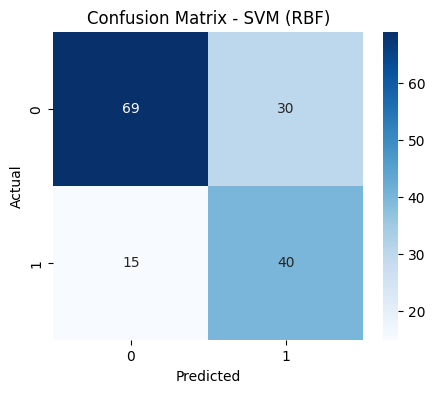

In [93]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (RBF)")
plt.show()

## ROC Curve

In [94]:
from sklearn.metrics import roc_curve, roc_auc_score

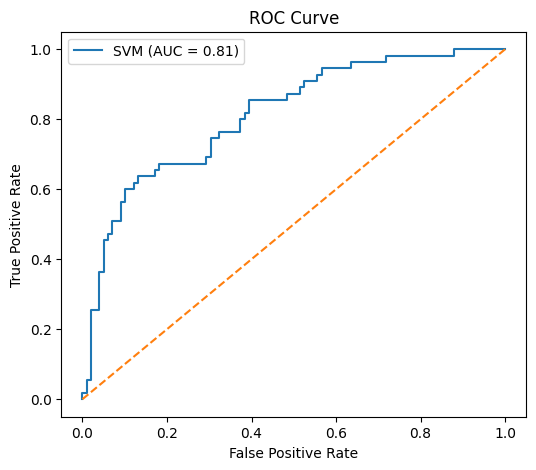

In [95]:
y_scores = svm_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="SVM (AUC = %.2f)" % roc_auc_score(y_test, y_scores))
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Check the overfitting and underfitting 

In [97]:
# Compare Train vs Test Accuracy
# Training Accurary
train_accuracy = svm_model.score(X_train, y_train)

In [98]:

# Test accuracy
test_accuracy = svm_model.score(X_test, y_test)

In [99]:
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.7719869706840391
Test Accuracy: 0.7077922077922078


In [100]:
from sklearn.metrics import roc_auc_score

# Train AUC
train_auc = roc_auc_score(y_train, svm_model.decision_function(X_train))

# Test AUC
test_auc = roc_auc_score(y_test, svm_model.decision_function(X_test))

print("Train AUC:", train_auc)
print("Test AUC:", test_auc)


Train AUC: 0.844344537716741
Test AUC: 0.8119375573921029


## Hypreparameter tuning

What We Are Tuning
🔹 C (Regularization parameter)

Small C → wider margin → simpler model → may underfit

Large C → narrower margin → complex model → may overfit

gamma (RBF parameter)

Small gamma → smooth decision boundary

Large gamma → complex boundary → risk of overfitting

Goal

Find best combination of:

C + gamma

In [101]:
from sklearn.model_selection import GridSearchCV

In [102]:
param_grid = {
    'C': [0.1, 1, 10, 50, 100],
    'gamma': ['scale', 0.01, 0.1, 1]
}

In [103]:
grid = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='roc_auc',   # we optimize for AUC
    verbose=1,
    n_jobs=-1
)


In [104]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC(class_weight='balanced')
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.1, 1, ...], 'gamma': ['scale', 0.01, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the

Get Best Parameters

In [105]:
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)


Best Parameters: {'C': 10, 'gamma': 0.01}
Best Cross-Validation Score: 0.8400041528239202


In [106]:
best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test)

In [107]:
print(classification_report(y_test, y_pred_best))

print("Test AUC:",
      roc_auc_score(y_test,
                    best_model.decision_function(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75        99
           1       0.57      0.75      0.65        55

    accuracy                           0.71       154
   macro avg       0.70      0.72      0.70       154
weighted avg       0.74      0.71      0.71       154

Test AUC: 0.8119375573921029


In [108]:
print("Train AUC:",
      roc_auc_score(y_train,
                    best_model.decision_function(X_train)))

Train AUC: 0.864353201503284


In [109]:
print("Test AUC:",
      roc_auc_score(y_test,
                    best_model.decision_function(X_test)))

Test AUC: 0.8119375573921029


In [110]:
y_pred_best = best_model.predict(X_test)


In [111]:
from sklearn.metrics import confusion_matrix

print("Confusion Matrix (After Tuning):\n",
      confusion_matrix(y_test, y_pred_best))

Confusion Matrix (After Tuning):
 [[68 31]
 [14 41]]


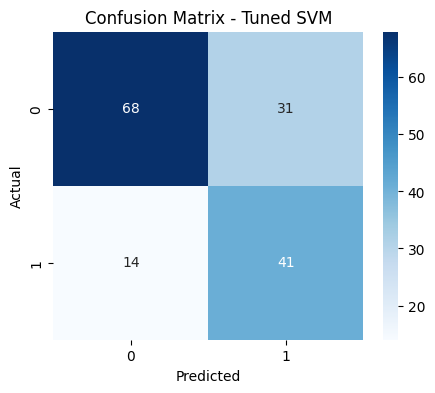

In [112]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned SVM")
plt.show()

## Save the model 

In [113]:
import pickle

In [114]:
# save Model
with open("../model/svm_model.pkl","wb") as f:
    pickle.dump(best_model,f)

In [ ]:
# save Scaler
with open("../model/scaler.pkl","wb") as f:
    pickle.dump(scaler,f)